Define Hyperparameters and Paths (Then You Can Just Run All of the Cells)

In [2]:
WELLS = ["CCS1", "VW1", "VW2"]      #wells being used
K_FOLDS = 10                        #number of folds used for K-Fold Validation
FRAC_THRESHOLD = 0.2                #threshold for probability of a fracture implies a fracture
MODEL_HYPERPARAMETERS = {
        'objective' : 'binary:logistic',
        'seed' : 42,
        'max_depth': 25,            #maximum depth of individual decision trees
        'n_estimators' : 100,       #number of individual decision trees
        'learning_rate': 0.08,      #learning rate
        'subsample' : 0.67,         #fraction of training samples used for training each tree
        'colsample_bytree' : 0.69,  #fraction of features used for training each tree
        'min_child_weight' : 3.7,   #minimum sum needed to be considered a leaf node
        'reg_alpha' : 0.53,
        'reg_lambda' : 0.07
      }

FORMATIONS = [                      #formations considered in model (comment out ones you want to ignore)
    "Eau Claire",
    "Mt. Simon E",
    "Mt. Simon D",
    "Mt. Simon C",
    "Mt. Simon B",
    "Mt. Simon A",
    "Argenta",
    "Precambrian"
    ]


DATALOGS_PATH = "REU Project/Data/Raw CSV Files/raw_"
LABELS_PATH = "REU Project/Data/labels/label_"
MODEL_DUMP_PATH = "REU Project/Models/XGBRClass/"

Imports

In [3]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, \
mean_absolute_error, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, \
RandomizedSearchCV, cross_val_score, KFold, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from random import randint, uniform

import matplotlib.pyplot as plt
import math

import seaborn
import joblib

Retrieve Data and Labels

In [4]:
datalogs = {}
labels = {}
datasets = {}
num_features = 0
for well in WELLS:
  datalogs_df = pd.read_csv(DATALOGS_PATH + well + ".csv")
  labels_df = pd.read_csv(LABELS_PATH + well + ".csv")

  #filter rock formations considered
  datalogs_df = datalogs_df[datalogs_df["FORM"].isin(FORMATIONS)]

  datalogs[well] = datalogs_df
  labels[well] = labels_df
  num_features = len(datalogs_df.columns) - 2 #exclude DEPT and FORM

  dataset = pd.merge(datalogs_df, labels_df, on='DEPT') #merge data and labels
  datasets[well] = dataset

  print(f"{well} : Shape of inputs= {datalogs_df.shape}")
  print(f"{well} : Shape of labels= {labels_df.shape}")
  print(f"{well} : Shape of merged= {dataset.shape}")

print(f"Num features: {num_features}")

CCS1 : Shape of inputs= (4217, 24)
CCS1 : Shape of labels= (4217, 2)
CCS1 : Shape of merged= (4217, 25)
VW1 : Shape of inputs= (3999, 24)
VW1 : Shape of labels= (3999, 2)
VW1 : Shape of merged= (3999, 25)
VW2 : Shape of inputs= (3413, 24)
VW2 : Shape of labels= (9130, 2)
VW2 : Shape of merged= (3413, 25)
Num features: 22


Optional Data Preprocessing Tools (Comment out function calls in final cell if you don't want to use)

In [5]:
def normalize(X_train, X_test):
  """
  Fit normalization to training data and apply to test data. Choose standard
  standard or MinMax Scaler.
  """
  scaler = StandardScaler()
  #scaler = MinMaxScaler(feature_range=(0, 1))
  X_train = scaler.fit_transform(X_train)
  X_test = scaler.transform(X_test)
  return X_train, X_test

In [6]:
def balance_dataset(dataset):
  """
  Undersample negative class to address bias in database. Adjust rat variable
  to change ratio of negative class to positive class data points.
  """
  df_0 = dataset[dataset['HAS_FRAC'] == 0]
  df_1 = dataset[dataset['HAS_FRAC'] == 1]

  # Randomly sample majority class so that it has rat times more data points
  # than minority class
  rat = 2
  min_samples = min(len(df_0), len(df_1))
  df_0_sampled = df_0.sample(n=min_samples * rat, replace=False)
  df_1_sampled = df_1.sample(n=min_samples, replace=False)

  # Concatenate the sampled DataFrames and shuffle
  balanced_df = pd.concat([df_0_sampled, df_1_sampled])
  balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)
  return balanced_df

In [7]:
def apply_PCA(X_train, X_test):
  """
  Returns components that explain n% of the data's variance. Adjust n variable
  to change what percentage of variance should be included. There is a more
  detailed analysis in the PCA analysis notebook.
  """
  print(f"Before PCA Xtrain, Xtest shapes: {X_train.shape}, {X_test.shape}")
  n = 0.8
  pca = PCA()
  train_pca_data = pca.fit_transform(X_train)
  test_pca_data = pca.transform(X_test)

  variance_explained = pca.explained_variance_ / np.sum(pca.explained_variance_)
  cumulative_variance_explained = np.cumsum(variance_explained)
  n_components = np.argmax(cumulative_variance_explained >= n) + 1

  new_X_train = train_pca_data[:, :n_components]
  new_X_test = test_pca_data[:, :n_components]
  print(f"After PCA Xtrain, Xtest shapes:\
   {new_X_train.shape}, {new_X_test.shape}")
  return new_X_train, new_X_test

Result Evaluation Tools

In [8]:
def print_metrics(accuracy, precision, recall, f1):
  """
  Print accuracy, precision, recall, and f1 scores.
  """
  print(f"Average accuracy is {(accuracy * 100).round(2)}%")
  print(f"Average precision is {(precision * 100).round(2)}%")
  print(f"Average recall is {(recall * 100).round(2)}%")
  print(f"Average f1 is {(f1 * 100).round(2)}%")

In [9]:
def plot_depths_with_labels(curr_well, depths, y_preds, test_labels):
  """
  Plots the depths that are predicted to contain fractures alongside the
  actual depths that contain fractures.
  """
  plt.figure(figsize=(8, 6))
  plt.ylabel("Depth [ft]")
  title = curr_well + "(Predictions | Truth)"
  plt.title(title)
  y_preds = [-y for y in y_preds]
  plt.barh(depths, y_preds, color="blue")
  plt.barh(depths, test_labels, color="gray")

  mind = math.floor(int(depths.min()) / 250) * 250
  maxd = math.floor(int(depths.max()) / 250) * 250
  plt.ylim(mind, maxd)
  plt.yticks(range(mind, maxd, 250))
  plt.xticks([])
  plt.gca().invert_yaxis()
  #plt.savefig(curr_well + '_XGBClassPlot.png', format='png', dpi=1200)
  plt.show()

In [10]:
def get_feat_import(X_train):
  """
  Calculates the importance scores of features in a dataset (calculated by
  incorporating the number of times the feature was split on + how influential
  that split was). Returns the features in descending importance order and their
  associated importance scores.
  """
  xgb_classifier = joblib.load(MODEL_DUMP_PATH + "model.joblib")
  importance_scores = xgb_classifier.feature_importances_

  # Sort feature importance scores and corresponding feature names
  sorted_indices = np.argsort(importance_scores)[::-1]
  sorted_features = X_train.columns[sorted_indices]

  return sorted_features, importance_scores[sorted_indices]

Train/Test Model Functions

In [11]:
def train_model(X, y):
  """
  Constructs an XBoost classifaction model (outputs 0 or 1), trains the model
  using the trainset (employs K-Fold cross validation), and prints the
  model's training performance.
  """
  hyperparameters = MODEL_HYPERPARAMETERS

  #helps avoid overfitting by prioritizing minority class
  num_pos = sum(y)
  num_neg = len(y) - num_pos
  hyperparameters['scale_pos_weight'] = num_neg / num_pos
  print("\nResults for training:")
  xgb_classifier = xgb.XGBClassifier(**hyperparameters)

  #train model applying K-Fold Cross Validation
  scoring=["accuracy", "precision", "recall", "f1"]
  #cv=KFold(n_splits=k, shuffle=True)
  cv = StratifiedKFold(n_splits=K_FOLDS, shuffle=True)
  results = cross_validate(xgb_classifier, X, y, cv=cv, scoring=scoring)
  xgb_classifier.fit(X, y)

  #calculate accuracy, precision, recall, and f1, and display them
  accuracy = np.mean(results['test_accuracy'])
  precision = np.mean(results['test_precision'])
  recall = np.mean(results['test_recall'])
  f1 = np.mean(results['test_f1'])
  print_metrics(accuracy, precision, recall, f1)

  joblib.dump(xgb_classifier, MODEL_DUMP_PATH + "model.joblib")

In [12]:
def test_model(X, y):
  """
  Apply trained XGBoost classifcation model to previously unseen test data,
  print results, and return predictions.
  """
  #load model and make predictions with unseen test data
  xgb_classifier = joblib.load(MODEL_DUMP_PATH + "model.joblib")
  y_pred = xgb_classifier.predict(X)

  #calculate and print performance
  accuracy = accuracy_score(y, y_pred)
  precision = precision_score(y, y_pred)
  recall = recall_score(y, y_pred)
  f1 = f1_score(y, y_pred)
  print("\nResults for testing:")
  print_metrics(accuracy, precision, recall, f1)
  return y_pred

Run Model on All Combination of Wells


Training on ['VW1', 'VW2'],   testing on CCS1

Results for training:
Average accuracy is 92.92%
Average precision is 76.63%
Average recall is 68.13%
Average f1 is 72.08%

Results for testing:
Average accuracy is 81.38%
Average precision is 18.62%
Average recall is 8.96%
Average f1 is 12.09%


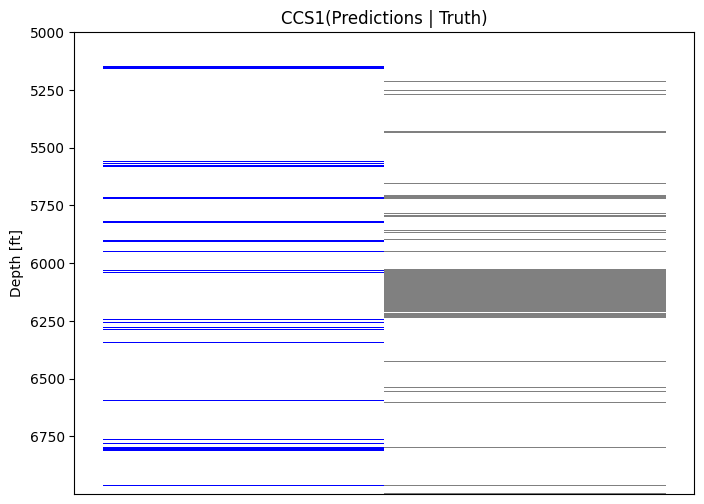


Training on ['CCS1', 'VW2'],   testing on VW1

Results for training:
Average accuracy is 93.37%
Average precision is 78.89%
Average recall is 69.66%
Average f1 is 73.94%

Results for testing:
Average accuracy is 75.27%
Average precision is 10.67%
Average recall is 10.02%
Average f1 is 10.34%


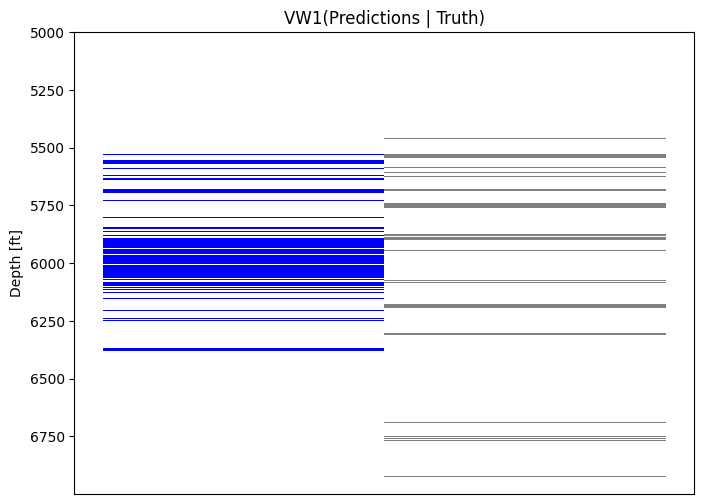


Training on ['CCS1', 'VW1'],   testing on VW2

Results for training:
Average accuracy is 93.99%
Average precision is 82.48%
Average recall is 73.72%
Average f1 is 77.77%

Results for testing:
Average accuracy is 84.47%
Average precision is 17.83%
Average recall is 6.53%
Average f1 is 9.56%


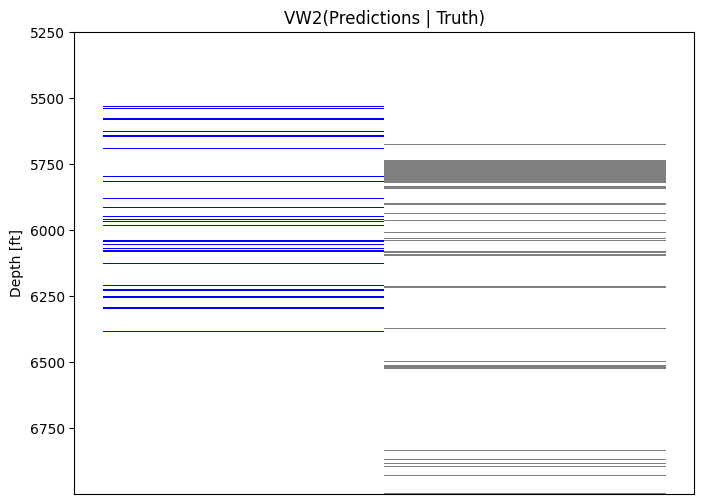

In [13]:
import_feats = {}
for i in range(len(WELLS)):
  ### iterate through which well is used for testing (rest used for training)
  curr_well = WELLS[i]
  testset = datasets[curr_well]
  print(f"\nTraining on {[well for well in WELLS if well != curr_well]},\
   testing on {curr_well}")
  trainsets = [datasets[well] for well in WELLS if well != curr_well]
  trainset = pd.concat(trainsets)
  test_depths = testset["DEPT"] #save for plotting

  ### optional undersampling of majority class
  #trainset = balance_dataset(trainset)

  X_train = np.array(trainset.drop(columns=["HAS_FRAC", "DEPT", "FORM"]))
  y_train = np.array(trainset["HAS_FRAC"])
  X_test = np.array(testset.drop(columns=["HAS_FRAC", "DEPT", "FORM"]))
  y_test = np.array(testset["HAS_FRAC"])

  ### optional data preprocessing steps
  X_train, X_test = normalize(X_train, X_test)
  #X_train, X_test = apply_PCA(X_train, X_test)

  ### train/test model and display results
  train_model(X_train, y_train)
  y_pred = test_model(X_test, y_test)

  plot_depths_with_labels(curr_well, test_depths, y_pred, y_test)

  ### keep track of feature importance scores
  feats, scores =  get_feat_import(trainset.drop(
                                          columns=["HAS_FRAC", "FORM", "DEPT"]))
  import_feats[curr_well] = [feats, scores]

Display Important Features For Each Well's Dataset


Important Features for Well CCS1:
1. RLA3: 0.10040470212697983
2. DTCO: 0.08034132421016693
3. DTSM: 0.07853122055530548
4. XWATER: 0.04613940790295601
5. KAOLINITE: 0.045160576701164246
6. BOUND_WATER: 0.04396553337574005
7. K-FELDSPAR: 0.042852338403463364
8. QUARTZ: 0.04185517132282257
9. CHLORITE: 0.04160268232226372
10. RLA2: 0.04120974615216255
11. PYRITE: 0.04097959026694298
12. PIGE: 0.04025155305862427
13. KSDR_PY: 0.03955252096056938
14. XIWATER: 0.03877157345414162
15. UWATER: 0.03863590583205223
16. RLA5: 0.03780747950077057
17. DOLOMITE: 0.03610675781965256
18. RHOZ: 0.035095591098070145
19. ILLITE: 0.034863971173763275
20. RLA4: 0.034489329904317856
21. RXOZ: 0.03208110108971596
22. N-FELDSPAR: 0.029301907867193222


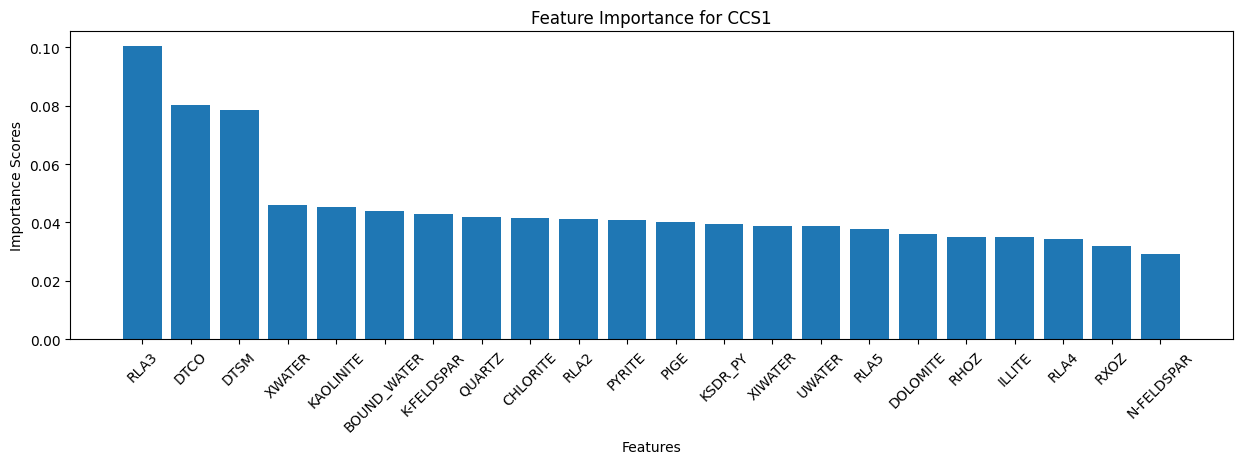

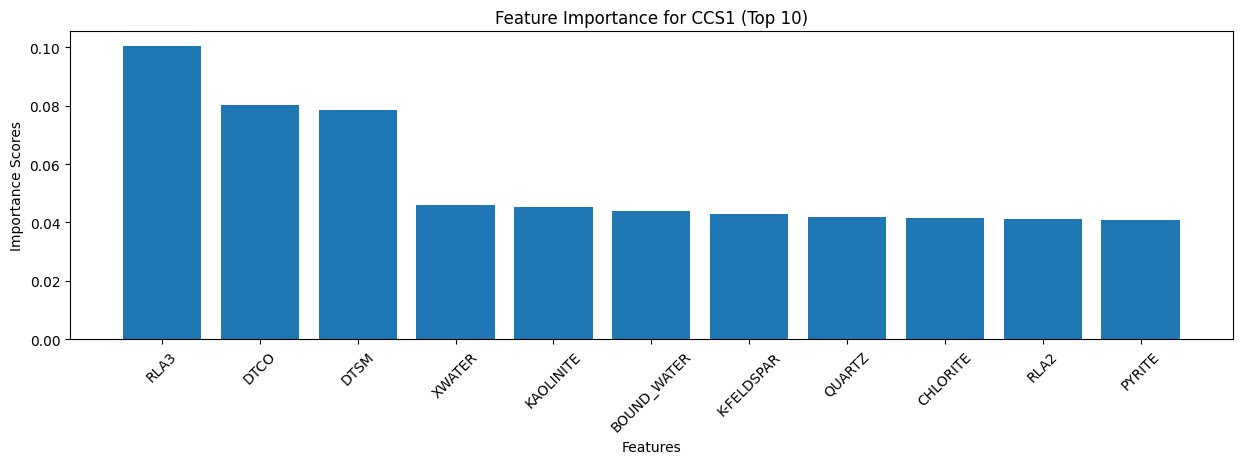


Important Features for Well VW1:
1. DTSM: 0.07068874686956406
2. PYRITE: 0.06628481298685074
3. QUARTZ: 0.06513005495071411
4. KSDR_PY: 0.05323178693652153
5. CHLORITE: 0.05017125606536865
6. K-FELDSPAR: 0.04756839945912361
7. DTCO: 0.04694216325879097
8. RHOZ: 0.04676690697669983
9. RLA3: 0.045664213597774506
10. RLA5: 0.04521973803639412
11. RLA4: 0.04466808959841728
12. KAOLINITE: 0.04327518865466118
13. BOUND_WATER: 0.042930275201797485
14. ILLITE: 0.04257064685225487
15. RXOZ: 0.04242609441280365
16. XIWATER: 0.03806838020682335
17. RLA2: 0.03759775683283806
18. DOLOMITE: 0.03600073978304863
19. N-FELDSPAR: 0.035744164139032364
20. UWATER: 0.03531172499060631
21. PIGE: 0.033168282359838486
22. XWATER: 0.030570674687623978


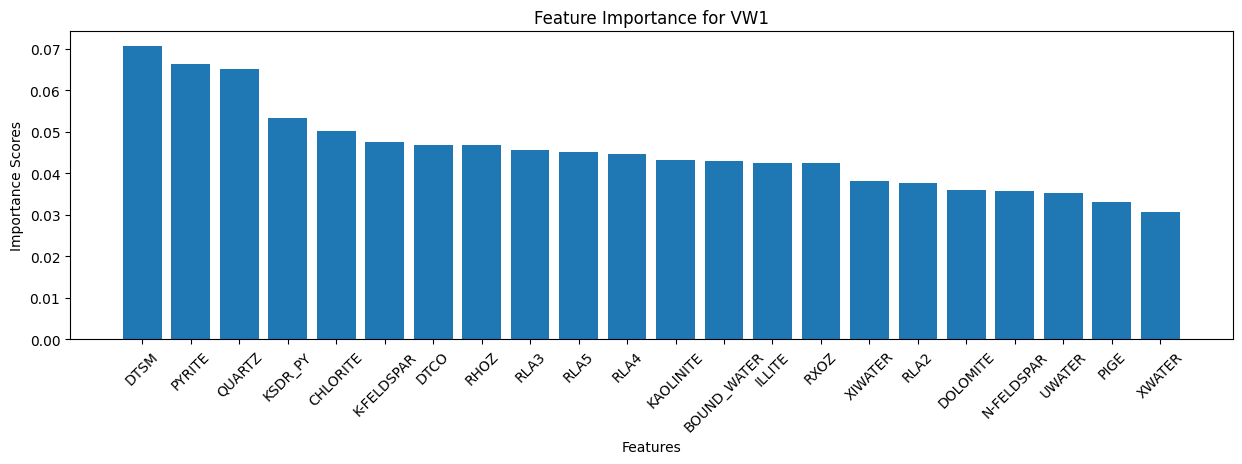

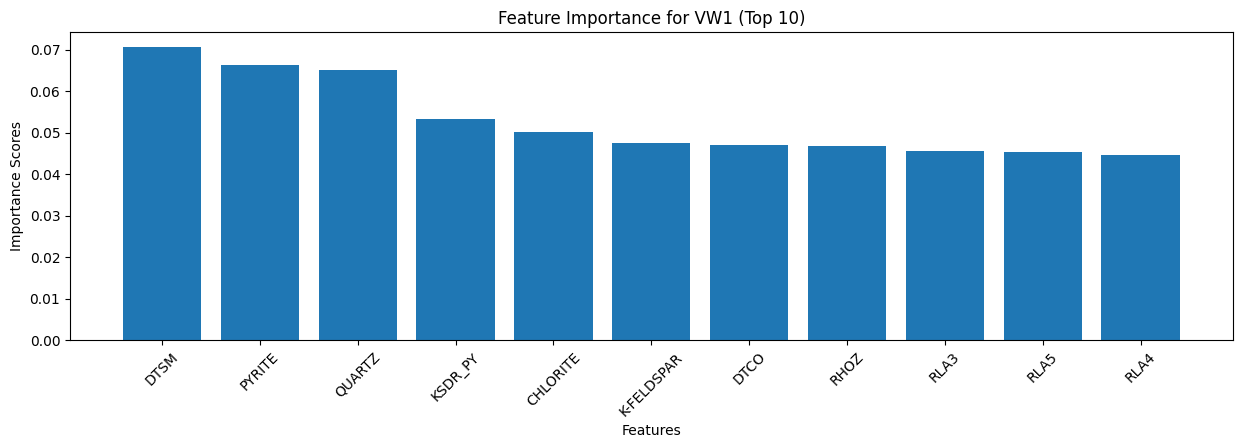


Important Features for Well VW2:
1. DTSM: 0.08575762063264847
2. DTCO: 0.06599101424217224
3. RXOZ: 0.06219463050365448
4. RLA2: 0.060951560735702515
5. QUARTZ: 0.05559731274843216
6. K-FELDSPAR: 0.04988537356257439
7. KAOLINITE: 0.04815414175391197
8. RLA3: 0.04722101241350174
9. BOUND_WATER: 0.04307937249541283
10. ILLITE: 0.042969927191734314
11. XWATER: 0.042392339557409286
12. RLA4: 0.04193463921546936
13. PIGE: 0.04059740528464317
14. KSDR_PY: 0.040523920208215714
15. PYRITE: 0.04031085968017578
16. RLA5: 0.0391341857612133
17. RHOZ: 0.037924811244010925
18. XIWATER: 0.033638644963502884
19. CHLORITE: 0.03279285505414009
20. N-FELDSPAR: 0.029857588931918144
21. DOLOMITE: 0.029665006324648857
22. UWATER: 0.029425794258713722


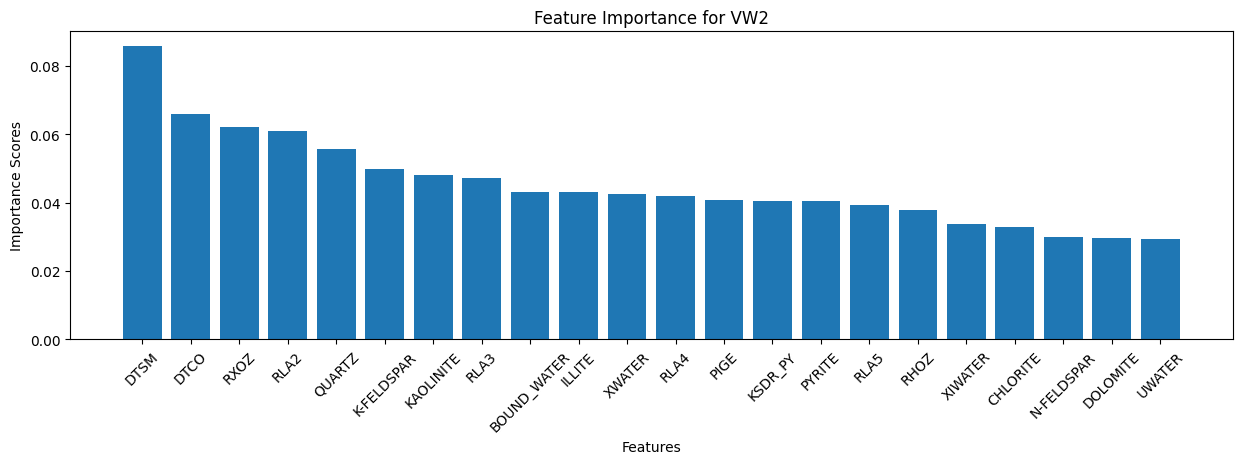

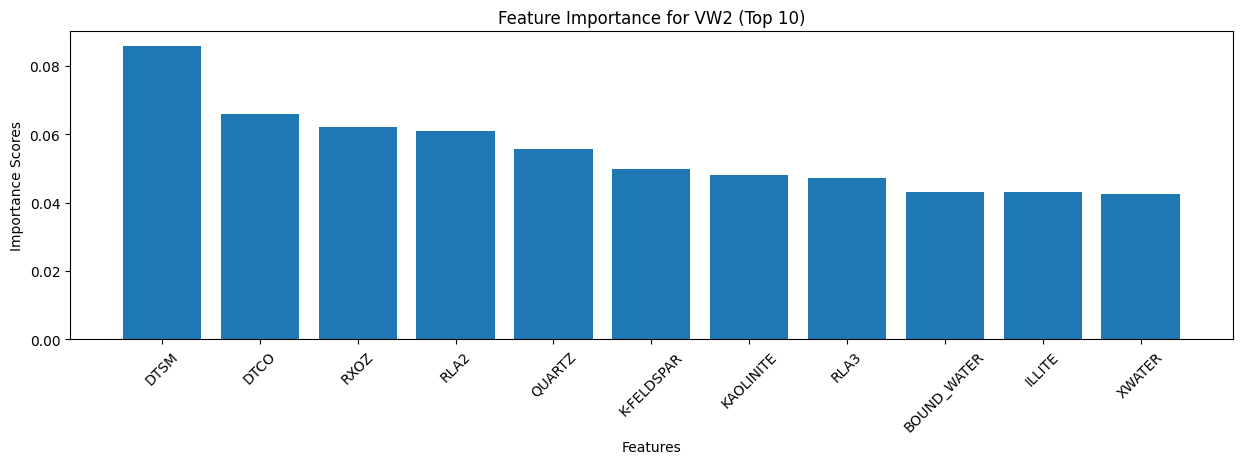

In [14]:
for well in WELLS: #iterate through relevant wells
  sorted_features, importance_scores = import_feats[well]

  # Print feature importance scores and corresponding feature names
  print(f"\nImportant Features for Well {well}:")
  counter = 1
  for feature, score in zip(sorted_features, importance_scores):
    print(f"{counter}. {feature}: {score}")
    counter += 1

  #Plot feature importance for each well
  plt.figure(figsize=(15, 4))
  plt.title('Feature Importance for ' + well)
  plt.bar(range(len(importance_scores)), importance_scores,
                                         tick_label=sorted_features)
  plt.xlabel('Features')
  plt.ylabel('Importance Scores')
  plt.xticks(rotation=45)
  plt.show()

  #Plot feature importance for each well (top 10)
  plt.figure(figsize=(15, 4))
  plt.title('Feature Importance for ' + well + " (Top 10)")
  plt.bar(range(11), importance_scores[:11], tick_label=sorted_features[:11])
  plt.xlabel('Features')
  plt.ylabel('Importance Scores')
  plt.xticks(rotation=45)
  plt.show()